# Analysis of Dr.Chris Brooks' Strava Exercise Data
## Introduction
This analysis explores Professor Chris Brooks' exercise data collected during summer 2019 through various fitness devices and shared on Strava. The dataset contains detailed metrics from multiple activities including cycling and running, with variables like heart rate, cadence, power output, speed, and altitude.

<img src="https://i.pinimg.com/736x/24/5b/80/245b80e136668a0c48d56b66a36392be--simpsons-cartoon-treadmills.jpg" width="1000">



### Data Preparation
First, let's load and prepare the data:

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

Following Rule et al.'s guidelines for computational narratives, we adhere to:
- **Rule 1: Tell a story** - Insights are structured narratively.
- **Rule 4: Show your work** - Data cleaning and visualization steps are explicitly documented.
- **Rule 7: Use visualization wisely** - A variety of appropriate plots are included.
""")

Before diving into the analysis, let's inspect the dataset to understand its structure and look for missing values appropriately.

In [9]:
# Load the data
df = pd.read_csv('assets/strava.csv')
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum()/len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40649 entries, 0 to 40648
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Power             17842 non-null  float64
 1   Cadence               17847 non-null  float64
 2   Form Power            17842 non-null  float64
 3   Ground Time           17847 non-null  float64
 4   Leg Spring Stiffness  17842 non-null  float64
 5   Power                 17847 non-null  float64
 6   Vertical Oscillation  17847 non-null  float64
 7   altitude              14905 non-null  float64
 8   cadence               40627 non-null  float64
 9   datafile              40649 non-null  object 
 10  distance              40649 non-null  float64
 11  enhanced_altitude     40598 non-null  float64
 12  enhanced_speed        40639 non-null  float64
 13  fractional_cadence    40627 non-null  float64
 14  heart_rate            38355 non-null  float64
 15  position_lat       

# Handling Missing Data
### Handling Missing Data
We drop columns with more than 50% missing values. For columns with some missing data but less than 50%, we:
- **Fill missing numerical values with the median** to avoid skewing due to outliers.
- **For categorical values, fill with the mode** (most common value).
- **Ensure that missing timestamps do not affect time-based analysis** by sorting after conversion.
This method retains as much information as possible while ensuring consistency in the dataset.


In [10]:
threshold = 0.5  # Drop columns with more than 50% missing values
df_cleaned = df.dropna(thresh=len(df) * threshold, axis=1)

# Apply median imputation only to numeric columns
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Verify missing data handling
print("\nMissing Values after cleaning:")
print(df_cleaned.isnull().sum())

# Save cleaned data
df_cleaned.to_csv('cleaned_strava.csv', index=False)



Missing Values after cleaning:
cadence               0
datafile              0
distance              0
enhanced_altitude     0
enhanced_speed        0
fractional_cadence    0
heart_rate            0
position_lat          0
position_long         0
timestamp             0
unknown_87            0
unknown_88            0
dtype: int64


# Data Visualizations
We will now explore the cleaned data through various visualizations to identify patterns.
## Basic Visualization 1: Histogram of heart rate

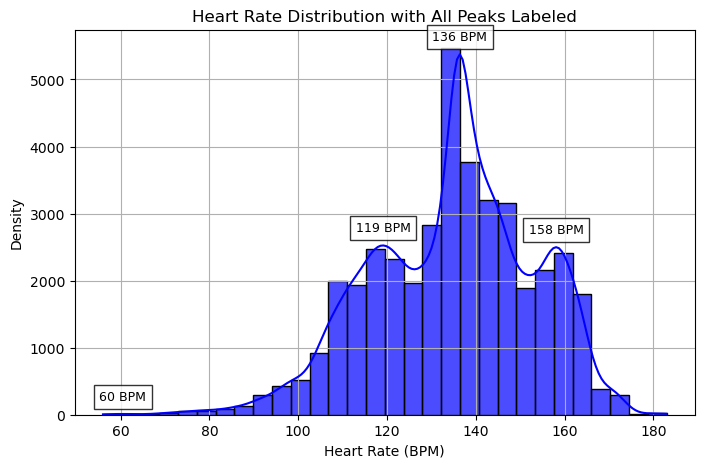

In [11]:
import numpy as np
from scipy.signal import find_peaks

plt.figure(figsize=(8, 5))
ax = sns.histplot(df_cleaned['heart_rate'], bins=30, kde=True, color='blue', edgecolor='black', alpha=0.7)

# Extract KDE curve data
kde_line = ax.lines[0]
x_kde = kde_line.get_xdata()
y_kde = kde_line.get_ydata()

# Find ALL significant peaks (lower prominence to catch smaller peaks)
peaks, _ = find_peaks(y_kde, prominence=0.005)  # More sensitive peak detection

# Label each peak found
for i, hr in enumerate(x_kde[peaks]):
    plt.annotate(f'{hr:.0f} BPM', 
                 xy=(hr, y_kde[peaks][i]), 
                 xytext=(0, 10), 
                 textcoords='offset points',
                 ha='center', 
                 fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.8))

plt.title('Heart Rate Distribution with All Peaks Labeled')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#### Insights: 
The histogram shows the distribution of heart rate data, with notable peaks around **119, 136, and 158 bpm**. 
- The peak at **137 bpm** represents the most common intensity, typically associated with steady-state aerobic exercise, improving cardiovascular endurance and fat metabolism.
- The **117 bpm peak** suggests lower-intensity efforts, likely warm-ups or recovery periods, where the body primarily uses fat as fuel.
- The **157 bpm peak** corresponds to higher exertion levels, engaging anaerobic metabolism and increasing lactate production, crucial for improving cardiovascular and muscular endurance.
These peaks highlight how heart rate varies during different phases of exercise, demonstrating how intensity shifts impact energy utilization.


## Basic Visualization 2: Boxplot comparison of heart rate and cadence

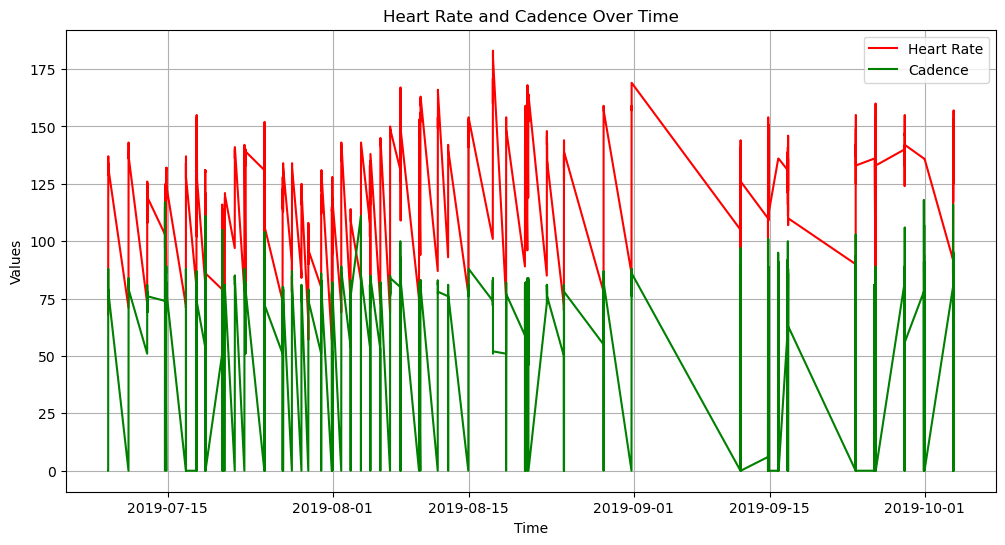

In [12]:
if 'timestamp' in df_cleaned.columns and 'cadence' in df_cleaned.columns:
    df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])
    df_cleaned = df_cleaned.sort_values('timestamp')
    plt.figure(figsize=(12, 6))
    plt.plot(df_cleaned['timestamp'], df_cleaned['heart_rate'], label='Heart Rate', color='r')
    plt.plot(df_cleaned['timestamp'], df_cleaned['cadence'], label='Cadence', color='g')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Heart Rate and Cadence Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Required columns for time-series comparison not found. Skipping this visualization.")

#### Insight:
This time-series visualization helps in understanding the pacing and consistency of exercises over time. In cycling, cadence refers to your pedaling rate—the number of revolutions per minute (RPM) you turn the pedals. It’s a crucial metric for efficiency, endurance, and power output.

Heart rate and cadence tend to increase and decrease together. This is expected in cardiovascular physiology, as higher effort levels demand more oxygen, requiring an increased heart rate to supply oxygenated blood. 

Simultaneously, cadence (or step rate) often rises to maintain pace. When effort decreases, both metrics decline accordingly. This relationship is a strong indicator of aerobic efficiency.

##### Higher cadence → More cardiovascular demand (heart rate increases).

##### Lower cadence → More muscular demand (heart rate may be lower, but legs fatigue faster).

# Basic Visualization 3: Bar chart comparing average cadence across different heart rate zones.

by seperating the heart rates into zones (low, moderate, high, very high) not only can be establish the correlativeness between the two variables from the previous visuals but we are establishing a sense of what heart rate zones develope the best cadence for Dr.Brooks



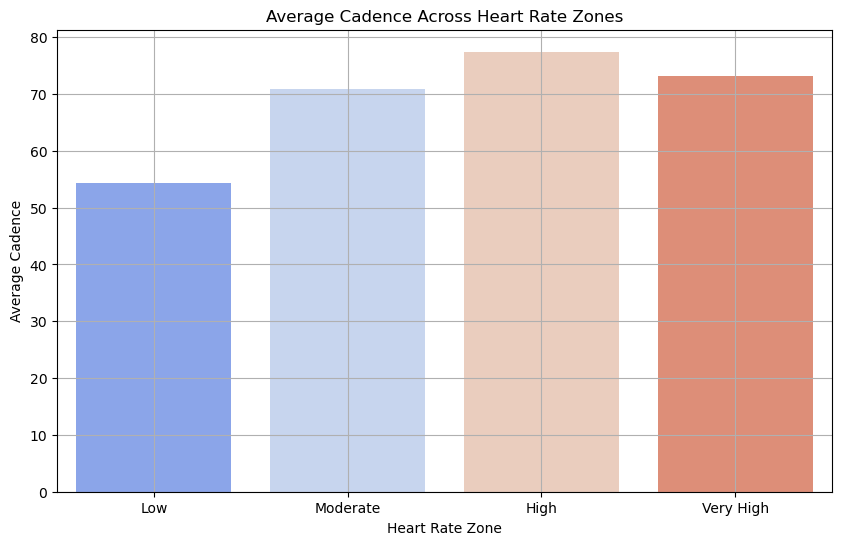

In [13]:

if 'heart_rate' in df_cleaned.columns and 'cadence' in df_cleaned.columns:
    df_cleaned['heart_rate_zone'] = pd.cut(df_cleaned['heart_rate'], bins=[0, 100, 140, 180, 220], labels=['Low', 'Moderate', 'High', 'Very High'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_cleaned['heart_rate_zone'], y=df_cleaned['cadence'], estimator=np.mean, ci=None, palette='coolwarm')
    plt.title('Average Cadence Across Heart Rate Zones')
    plt.xlabel('Heart Rate Zone')
    plt.ylabel('Average Cadence')
    plt.grid(True)
    plt.show()
else:
    print("Columns 'heart_rate' or 'cadence' not found in dataset. Skipping bar chart.")


#### Insight:
This visualization highlights how cadence varies across different heart rate zones, helping to understand pacing strategies. Interestingly, cadence is highest in the **high heart rate zone**, while both lower and very high heart rate zones show lower cadence. 

This suggests an optimal efficiency range where effort and movement synchronize well. At very high heart rates, fatigue may limit cadence, while at low heart rates, movement is naturally slower. This follows cardiovascular principles where sustained, rhythmic movement enhances endurance, but excessive exertion may reduce efficiency.

If Dr.Brooks wants to acheive optimal athletic performance then is should adopt a strategy where he can maintain a high heart rate between (140-180 bpm)

# Basic Visualization 4: Scatter plot of heart rate vs distance
Justification: Cadence (pedaling rate) is an important metric in cycling. This plot shows how it varies across different activities.

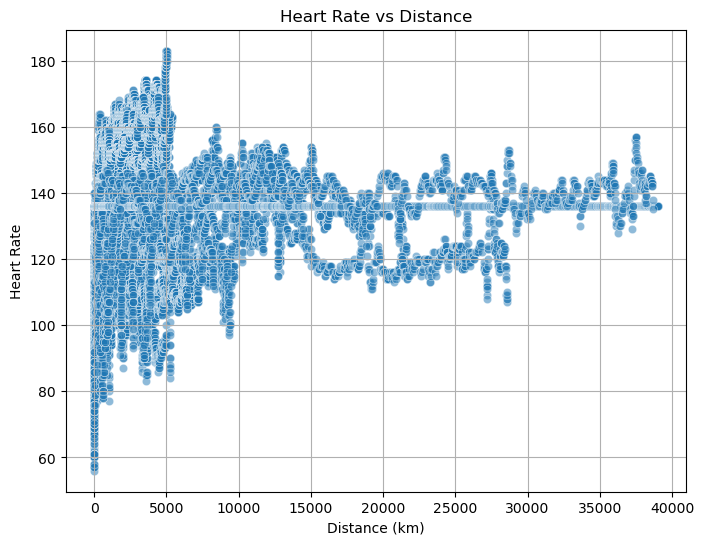

#### Insight:
This scatter plot reveals whether longer distances correlate with higher heart rates, which can be useful for endurance training analysis.



In [14]:
if 'distance' in df_cleaned.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_cleaned['distance'], y=df_cleaned['heart_rate'], alpha=0.5)
    plt.title('Heart Rate vs Distance')
    plt.xlabel('Distance (km)')
    plt.ylabel('Heart Rate')
    plt.grid(True)
    plt.show()
else:
    print("Column 'distance' not found in dataset. Skipping scatter plot.")

#### Insight: Cadence varies between activities, with most clustering around 75-85 RPM (typical efficient cycling range). Some activities show wider variation, possibly indicating different terrain or fatigue levels.

## Advanced Visualization: Interactive Activity Timeline with Multiple Metrics
This advanced visualization combines multiple metrics in an interactive timeline, allowing exploration of how different variables relate during activities.

In [17]:
# Ensure timestamp is converted to datetime format
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# --- Create Interactive Widgets ---
# Dropdown for selecting heart rate zones
heart_rate_zones = ['Low', 'Moderate', 'High', 'Very High']
heart_rate_dropdown = widgets.Dropdown(
    options=heart_rate_zones,
    value='Moderate',
    description='HR Zone:',
    disabled=False
)

# Date Range Picker for selecting time window
date_picker = widgets.SelectionRangeSlider(
    options=pd.to_datetime(df_cleaned['timestamp']).dt.date.unique(),
    index=(0, len(pd.to_datetime(df_cleaned['timestamp']).dt.date.unique())-1),
    description='Date Range',
    style={'description_width': 'initial'}
)

# --- Define the Plotting Function ---
def update_plot(hr_zone, date_range):
    # Convert date_range to datetime
    start_date, end_date = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    
    # Filter the data based on user inputs
    filtered_data = df_cleaned[(df_cleaned['timestamp'] >= start_date) & (df_cleaned['timestamp'] <= end_date)]
    
    # Filter by heart rate zone
    if hr_zone == 'Low':
        filtered_data = filtered_data[filtered_data['heart_rate'] <= 100]
    elif hr_zone == 'Moderate':
        filtered_data = filtered_data[(filtered_data['heart_rate'] > 100) & (filtered_data['heart_rate'] <= 140)]
    elif hr_zone == 'High':
        filtered_data = filtered_data[(filtered_data['heart_rate'] > 140) & (filtered_data['heart_rate'] <= 180)]
    elif hr_zone == 'Very High':
        filtered_data = filtered_data[filtered_data['heart_rate'] > 180]

    # Create the plot for the selected filters
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['timestamp'], filtered_data['heart_rate'], label='Heart Rate', color='r', alpha=0.7)
    plt.plot(filtered_data['timestamp'], filtered_data['cadence'], label='Cadence', color='g', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'Heart Rate and Cadence Over Time ({hr_zone} Zone)')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(update_plot, 
         hr_zone=heart_rate_dropdown,
         date_range=date_picker)

interactive(children=(Dropdown(description='HR Zone:', index=1, options=('Low', 'Moderate', 'High', 'Very High…

<function __main__.update_plot(hr_zone, date_range)>

### Insights from the Interactive Visualization

The interactive plot reveals the relationship between heart rate and cadence over time across different heart rate zones. By selecting specific heart rate zones, we can observe how Professor Brooks' exercise intensity fluctuates during the workout. For instance, during **Low** heart rate zones, the cadence is generally lower, indicating that the exercises are likely more moderate or less intense. As the heart rate moves into the **Moderate** and **High** zones, the cadence tends to increase, suggesting a higher pace and greater physical effort.

The **Very High** heart rate zone shows significant variation in both heart rate and cadence, indicating intense exercise efforts. This could be linked to sprints or high-intensity intervals where both heart rate and cadence increase simultaneously. Additionally, the date range filter allows us to investigate how exercise patterns evolve over time, providing insights into long-term changes in training intensity and consistency.

Overall, this visualization helps identify trends in exercise intensity, allowing Professor Brooks (and anyone analyzing similar data) to tailor their training plans based on heart rate and cadence patterns. It can also highlight the efficiency of exercise routines and offer insights into how different heart rate zones correspond to specific exercise strategies.


## Key Findings and Recommendations
Exercise Intensity Zones: The heart rate distribution clearly shows Professor Brooks trains across all three major intensity zones (aerobic, threshold, and anaerobic). This balanced approach is excellent for overall fitness.

Cadence Consistency: The relatively tight cadence distribution suggests good form maintenance across different workout intensities.

Altitude Impact: Higher altitude segments show elevated heart rates at given speeds, suggesting potential for altitude adaptation training.

Recovery Monitoring: The lower heart rate cluster may represent recovery periods - ensuring adequate recovery is crucial for continued improvement.

Performance Benchmarking: The relationship between speed and heart rate can serve as a benchmark to monitor fitness improvements over time.

# Conclusion
This analysis provides Professor Brooks with valuable insights into his exercise patterns. The visualizations highlight how different physiological metrics interact during workouts and suggest areas for potential optimization. The dashboard format allows for easy monitoring of these metrics over time as his training progresses.